In [1]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from functools import partial

In [2]:
# Constants
NUM_ARMS = 10       # Number of arms in the bandit
NUM_RUNS = 2000     # Number of independent runs
NUM_STEPS = 1000    # Number of time steps per run

In [3]:
class Bandit:
    """
    Multi-armed bandit environment.
    """
    def __init__(self, k_arm=NUM_ARMS):
        """
        Initialize the bandit with true action values drawn from a normal distribution.
        """
        self.k = k_arm
        self.q_true = np.random.normal(0, 1, self.k)  # True action values
        self.optimal_action = np.argmax(self.q_true)   # Index of the optimal action

    def step(self, action):
        """
        Generate a reward for the selected action.
        Reward is drawn from a normal distribution centered at the true action value.
        """
        reward = np.random.normal(self.q_true[action], 1)
        return reward
    

In [4]:
class Agent:
    """
    Agent that interacts with the bandit.
    """
    def __init__(self, k_arm=NUM_ARMS, Q_initial=0.0, epsilon=0.0, alpha=0.1):
        """
        Initialize the agent.
        
        Parameters:
        - k_arm: Number of arms.
        - Q_initial: Initial estimates of action values.
        - epsilon: Exploration rate.
        - alpha: Step size for updating estimates.
        """
        self.k = k_arm
        self.Q = np.full(self.k, Q_initial, dtype=float)  # Estimated action values
        self.epsilon = epsilon
        self.alpha = alpha

    def select_action(self):
        """
        Select an action using epsilon-greedy policy.
        """
        if np.random.rand() < self.epsilon:
            # Explore: select a random action
            action = np.random.randint(self.k)
        else:
            # Exploit: select the action with the highest estimated value
            action = np.argmax(self.Q)
        return action

    def update(self, action, reward):
        """
        Update the estimated value of the selected action using constant step size.
        """
        self.Q[action] += self.alpha * (reward - self.Q[action])
    

In [5]:
def single_run(agent_class, Q_initial, epsilon, alpha, k_arm=NUM_ARMS, num_steps=NUM_STEPS, seed=None):
    """
    Simulate a single run of the agent interacting with the bandit.
    
    Returns:
    - optimal_action_record: Array indicating whether the optimal action was selected at each time step.
    """
    if seed is not None:
        np.random.seed(seed)
    # Initialize bandit environment
    env = Bandit(k_arm)
    # Initialize agent
    agent = agent_class(k_arm, Q_initial, epsilon, alpha)
    # Record whether the optimal action was selected at each time step
    optimal_action_record = np.zeros(num_steps)
    for step in range(num_steps):
        # Agent selects an action
        action = agent.select_action()
        # Environment returns a reward
        reward = env.step(action)
        # Agent updates its estimates
        agent.update(action, reward)
        # Record if the selected action is optimal
        if action == env.optimal_action:
            optimal_action_record[step] = 1
    return optimal_action_record


In [6]:
def run_simulation(agent_class, Q_initial, epsilon, alpha, num_runs=NUM_RUNS, num_steps=NUM_STEPS):
    """
    Run multiple simulations in parallel and aggregate the results.
    
    Returns:
    - optimal_action_counts: Percentage of optimal action selections over time.
    """
    # Generate a list of seeds for reproducibility
    seeds = np.random.randint(0, 1000000, size=num_runs)
    # Partial function to fix the agent parameters
    single_run_partial = partial(single_run, agent_class, Q_initial, epsilon, alpha, NUM_ARMS, num_steps)
    # Run simulations in parallel
    results = Parallel(n_jobs=-1)(delayed(single_run_partial)(seed=seed) for seed in seeds)
    # Convert results to numpy array
    results = np.array(results)
    # Compute average optimal action percentage over time
    optimal_action_counts = np.mean(results, axis=0) * 100  # Convert to percentage
    return optimal_action_counts


Running simulation for: Optimistic Greedy (Q₁=5, ε=0)
Running simulation for: Realistic ε-Greedy (Q₁=0, ε=0.1)


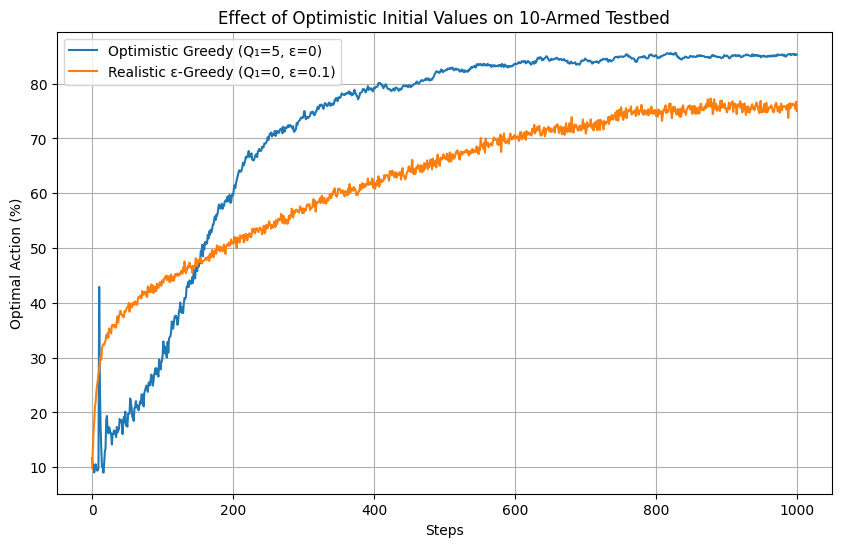

In [7]:
def main():
    """
    Main function to run simulations and plot the results.
    """
    # Parameters for the two methods
    methods = [
        {
            'label': 'Optimistic Greedy (Q₁=5, ε=0)',
            'Q_initial': 5.0,
            'epsilon': 0.0,
            'alpha': 0.1
        },
        {
            'label': 'Realistic ε-Greedy (Q₁=0, ε=0.1)',
            'Q_initial': 0.0,
            'epsilon': 0.1,
            'alpha': 0.1
        }
    ]
    
    # Collect results
    results = []
    
    for method in methods:
        print(f"Running simulation for: {method['label']}")
        optimal_action_counts = run_simulation(
            agent_class=Agent,
            Q_initial=method['Q_initial'],
            epsilon=method['epsilon'],
            alpha=method['alpha'],
            num_runs=NUM_RUNS,
            num_steps=NUM_STEPS
        )
        results.append((method['label'], optimal_action_counts))
    
    # Plot the results
    plt.figure(figsize=(10, 6))
    for label, optimal_action_counts in results:
        plt.plot(optimal_action_counts, label=label)
    plt.xlabel('Steps')
    plt.ylabel('Optimal Action (%)')
    plt.title('Effect of Optimistic Initial Values on 10-Armed Testbed')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()
    